In [4]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)

from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy


## Draw the boxes on document pages

In [5]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [36]:
base_dir   = '/Users/kd/Workspace/python/github/document-structure/data/'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = 'Testa_Dummy_ImuPro_okt2018_5725.pdf'


os.system('mkdir -p {0}'.format(input_dir))

os.system('mkdir -p {0}'.format(output_dir))



0

In [37]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: Testa_Dummy_ImuPro_okt2018_5725.pdf


In [38]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (5) in file (Testa_Dummy_ImuPro_okt2018_5725.xml)


In [39]:
document_configs = {
    'LANGUAGE_TYPE': 'eng',
    
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [45]:
file_index     = 1

img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]


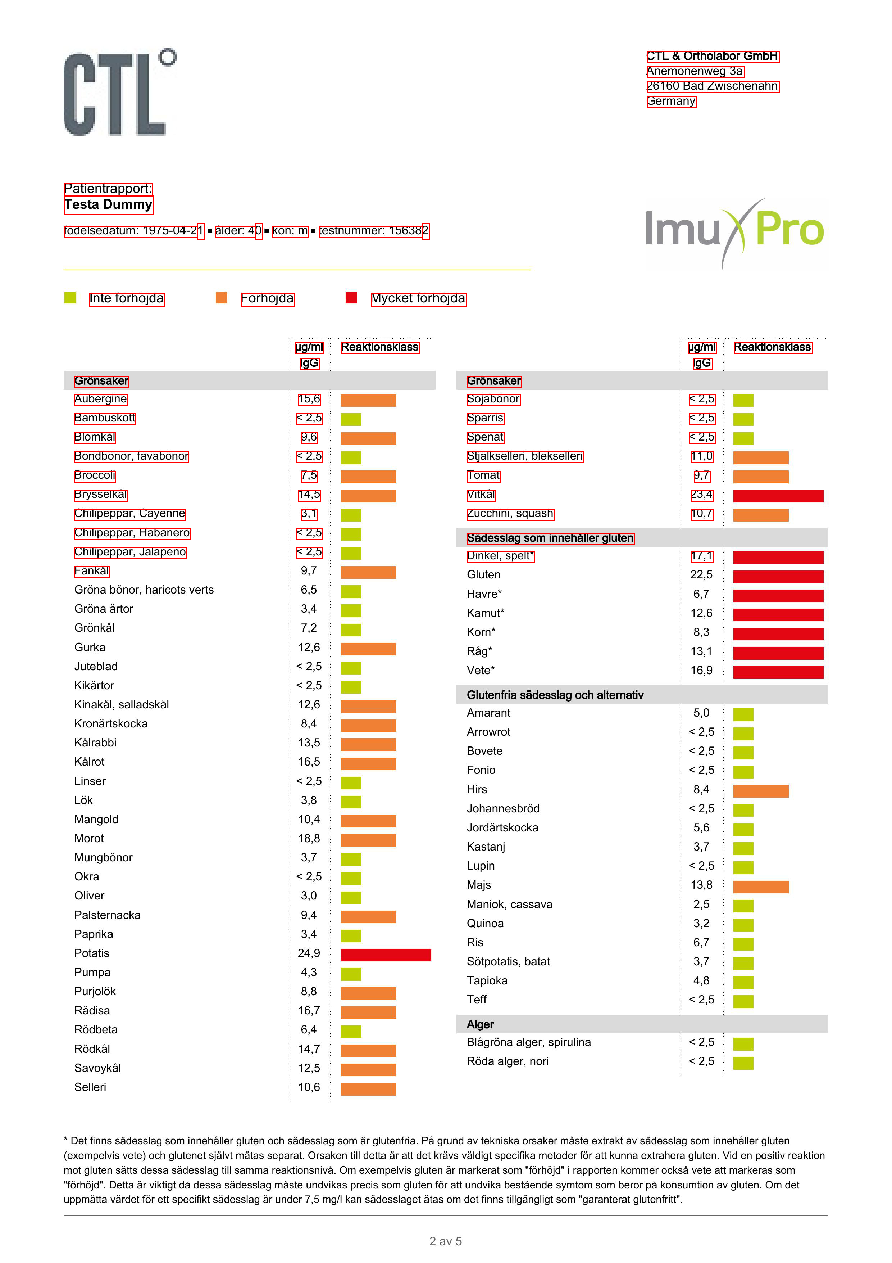

In [53]:
in_df   = df.loc[:60]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

draw_box(img_filepath, page_width, page_height, in_df, color='red')
# show_df(in_df)


In [51]:
in_df.sort_values(by=['text_left', 'text_top'], axis = 0, ascending = True, inplace=True)
show_df(in_df)


/Users/kd/miniconda3/envs/cv3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color
4,1,183,64,88,13,Patientrapport:,13,FNNZVW+ArialMT,#000000
5,2,195,64,89,19,Testa Dummy,13,"ZMVXWY+Arial,Bold",#000000
10,3,226,64,133,11,födelsedatum: 1975-04-2,12,FNNZVW+ArialMT,#000000
22,20,376,74,54,11,Grönsaker,11,FNNZVW+ArialMT,#000000
27,21,394,74,53,11,Aubergine,11,FNNZVW+ArialMT,#000000
29,23,413,74,61,11,Bambuskott,11,FNNZVW+ArialMT,#000000
13,14,293,89,75,13,Inte förhöjda,13,FNNZVW+ArialMT,#000000
6,4,223,197,7,16,1,12,ZMVXWY+Arial,#000000
11,5,226,215,40,11,ålder: 4,12,FNNZVW+ArialMT,#000000
14,15,293,241,53,13,Förhöjda,13,FNNZVW+ArialMT,#000000


In [15]:
def process_block(children):
    df      = pd.read_json(children)
    df.sort_values('text_top', axis = 0, ascending = True, inplace=True)
    return df

In [16]:
c_df = process_block(v_df.loc[0]['children'])
show_df(c_df)

,children,font_color,font_family,font_size,text,text_height,text_left,text_top,text_width,xml_index
0,NaN,#000000,FNNZVW+ArialMT,12,CTL & Ortholabor GmbH,11,647,51,132,10
1,NaN,#000000,FNNZVW+ArialMT,12,Anemonenweg 3a,11,647,66,97,11
2,NaN,#000000,FNNZVW+ArialMT,12,26160 Bad Zwischenahn,11,647,81,132,12
3,NaN,#000000,FNNZVW+ArialMT,12,Germany,11,647,96,49,13
4,NaN,#000000,FNNZVW+ArialMT,13,Patientrapport:,13,64,183,88,1
